<a href="https://colab.research.google.com/github/surabhitri/multimodal_recommender_system/blob/main/Fashion_Finder_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion Finder App Tutorial - Part 1

### Intro
Have you ever browsed through photo-sharing sites like Instagram or Pinterest, spotted an outfit you loved, but had no idea where to find the clothing? This tutorial will guide you through building an application that allows you to upload a photo of any outfit or type in a text description, and then suggests similar apparel pieces to help you recreate the look.

### Overview
In this notebook, you'll learn how to leverage Google Vertex AI, Weaviate vector database, Google's multimodal embeddings, Retrieval-Augmented Generation (RAG), and Weaviate's hybrid search feature. By combining these tools, you'll perform vector similarity searches and build a sophisticated multi-modal Recommender System.

### Before you get started
Make sure you have the following accounts:


*   **Weaviate Cloud account:** Sign up for a free 14-day trial account [here](https://weaviate.io/developers/wcs).
*   **Vertex AI account:** Sign up [here](https://cloud.google.com/vertex-ai?hl=en) (ensure you have a billing account added).
* **Google AI Studio account:** Sign up [here](https://ai.google.dev/aistudio).


And, the associated API keys:
* **GCP_PROJECT_ID:** Can be found in Google cloud console.
* **X-Google-Vertex-API-Key:** Upload your service account key as a JSON file from the Google Cloud Console to session storage by clicking the files tab in the left sidebar. [See instructions here](https://cloud.google.com/iam/docs/keys-create-delete).
* **X-Google-Studio-API-Key:** Can be found in the Google AI Studio account dashboard.
* **WCS_API_KEY:** Can be found in the Weaviate Cloud account dashboard.
* **WCS_URL:** Can be found in the Weaviate Cloud account dashboard.
* **Kaggle Token:** Upload your Kaggle API as a json file to session storage by clicking the files tab in the left sidebar. See instructions [here](https://www.kaggle.com/docs/api).

**NOTE:** Please store your X-Google-Studio-Api-Key, WCS_URL, WCS_API_KEY, GCP_PROJECT_ID to Secrets using the left sidebar.



# Install Initial Dependencies

In [ ]:
!pip install pandas
!pip install numpy
!pip install kaggle
!pip install google-cloud-aiplatform
!pip install google-generativeai

In [ ]:
!pip install python-dotenv
!pip install -U weaviate-client

In [2]:
import pandas as pd
import os
import io

# Load Kaggle API and Fashion Dataset

In [3]:
# Make a new directory Kaggle and copy your Kaggle API json file to it
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Download fashion data from Kaggle

In [4]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-dataset -f fashion-dataset/images.csv

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset
License(s): copyright-authors
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 117MB/s]


In [5]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-dataset -f fashion-dataset/styles.csv

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset
License(s): copyright-authors
  0% 0.00/914k [00:00<?, ?B/s]
100% 914k/914k [00:00<00:00, 106MB/s]


In [6]:
#unzip the images.csv.zip file and save it to a pandas dataframe
!unzip images.csv.zip
images_df = pd.read_csv('images.csv')

Archive:  images.csv.zip
  inflating: images.csv              


In [7]:
images_df.head()

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...


In [8]:
#unzip the styles.csv.zip file and save it to a pandas dataframe
!unzip styles.csv.zip
styles_df = pd.read_csv('styles.csv', usecols=range(10)) #read only the first 10 columns - there are some entries which have error values in the 11th column

Archive:  styles.csv.zip
  inflating: styles.csv              


In [9]:
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [10]:
# Data cleaning and merging
images_df['id'] = images_df['filename'].str[:-4]  # Remove ".jpeg" from the id column in images_df
images_df['id'] = images_df['id'].astype(int) # Convert the 'id' column in images_df to integers
fashion_df = pd.merge(images_df, styles_df, on='id') #merge the two dataframes on the id column

In [11]:
fashion_df.head()

,filename,link,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


# Configure Google Vertex AI Credentials

In [12]:
from google.colab import userdata
from google.auth.transport.requests import Request
from google.oauth2.service_account import Credentials

In [13]:
# Upload your service account key file from Google cloud console to session storage
key_path = "mm-rag-recommender-05d612029f32.json"

In [14]:
def get_credentials() -> Credentials:
    credentials = Credentials.from_service_account_file(
        key_path,
        scopes=[
            "https://www.googleapis.com/auth/generative-language",
            "https://www.googleapis.com/auth/cloud-platform",
        ],
    )
    request = Request()
    credentials.refresh(request)
    return credentials

In [15]:
# This token is your X-Google-Vertex-Api-Key
credentials = get_credentials()
token = credentials.token

# Connect to Weaviate Cloud Instance

In [16]:
import weaviate
from weaviate.auth import AuthApiKey

# Recommended: save sensitive data as secrets
# Save your X-Google-Studio-Api-Key, WCS_URL, WCS_API_KEY, GCP_PROJECT_ID to Secrets in the left sidebar

studio_key = userdata.get("STUDIO_APIKEY")

client = weaviate.connect_to_wcs(
    cluster_url=userdata.get("WCS_URL"),                       # `weaviate_url`: your Weaviate URL
    auth_credentials=AuthApiKey(userdata.get("WCS_API_KEY")),  # `weaviate_key`: your Weaviate API key
    headers={
        "X-Google-Vertex-Api-Key": token,
        "X-Google-Studio-Api-Key": studio_key,                 # Your Google AI Studio API key
    }
)

client.is_ready()

True

In [ ]:
# client.close()

# Make dataset for vector database

**NOTE:** The Kaggle fashion dataset we downloaded contains 44,000 items, but for our recommender system, we'll only use 2,000 items due to the time and cost associated with creating embeddings (generating embeddings for 2,000 items cost less than $1). However, you are welcome to import more items for experimentation. Increasing the number of items in our vector database will enhance the quality of recommendations, as the system will have a larger pool of items to search through and return relevant results.

In [17]:
# Select random 2000 rows
bulk_dataset = fashion_df.sample(n=2000, random_state=1) #change n if you want to increase/ decrease the number of items
bulk_dataset.head()

,filename,link,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
665,42045.jpg,http://assets.myntassets.com/v1/images/style/p...,42045,Men,Footwear,Shoes,Casual Shoes,Yellow,Summer,2012.0,Casual,Nike Men Wardour Chukka Yellow Casual Shoes
2343,11913.jpg,http://assets.myntassets.com/v1/images/style/p...,11913,Men,Footwear,Sandal,Sandals,Black,Summer,2013.0,Casual,Franco Leone Men Casual Black Sandals
13746,15077.jpg,http://assets.myntassets.com/v1/images/style/p...,15077,Women,Apparel,Topwear,Kurtas,White,Fall,2011.0,Ethnic,Mother Earth Women Printed White Kurtas
43880,9081.jpg,http://assets.myntassets.com/v1/images/style/p...,9081,Men,Apparel,Bottomwear,Shorts,Red,Fall,2011.0,Sports,ADIDAS Men Gfx Rev 2l Sho Red Shorts
20839,34244.jpg,http://assets.myntassets.com/v1/images/style/p...,34244,Men,Apparel,Topwear,Tshirts,Yellow,Summer,2012.0,Casual,Proline Men Yellow T-shirt with Printed Detail


In [18]:
# Divide dataset into two subsets for easier import and debugging
bulk_dataset_1 = bulk_dataset.head(1000)
bulk_dataset_2 = bulk_dataset.tail(1000)

# Make Weaviate Collection

In [19]:
from weaviate.classes.config import Property, DataType, Configure, Multi2VecField

In [ ]:
client.collections.create(
    name="FashionCollection",
    properties=[
        Property(name="link", data_type=DataType.TEXT),
        Property(name="prod_id", data_type=DataType.INT),
        Property(name="prod_img", data_type=DataType.BLOB),
        Property(name="gender", data_type=DataType.TEXT),
        Property(name="masterCategory", data_type=DataType.TEXT),
        Property(name="subCategory", data_type=DataType.TEXT),
        Property(name="articleType", data_type=DataType.TEXT),
        Property(name="baseColour", data_type=DataType.TEXT),
        Property(name="season", data_type=DataType.TEXT),
        Property(name="usage", data_type=DataType.TEXT),
        Property(name="productDisplayName", data_type=DataType.TEXT),
    ],
    vectorizer_config=[
        Configure.NamedVectors.multi2vec_palm(
            name="_vector",
            # Define the fields to be used for the vectorization - using image_fields, text_fields, video_fields
            image_fields=[
                Multi2VecField(name="prod_img", weight=0.5)
            ],
            text_fields=[
                Multi2VecField(name="productDisplayName", weight=0.5)
            ],
            project_id=userdata.get('GCP_PROJECT_ID'),
            location="us-central1",
            model_id="multimodalembedding@001",
            dimensions=1408,
        )
    ],
    # Additional parameters not shown
)

# Import Data to Weaviate Collection

In [20]:
# Helper function to convert image url to base64 encoded representation
import base64
import urllib.request

def toBase64(url):
  """
  Downloads an image file from the given URL and returns its base64 encoded representation.

  Args:
      url: The URL of the file to download.

  Returns:
      The base64 encoded string of the downloaded file content.
  """
  # Download the file from the URL
  response = urllib.request.urlopen(url)
  # Read the downloaded content as bytes
  file_content = response.read()

  # Use the existing toBase64 function to encode the downloaded content
  return base64.b64encode(file_content).decode('utf-8')

## Import bulk dataset 1 to Weaviate collection



**NOTE:** This step should take between 10-20 minutes depending on your internet speed.

In [ ]:
from weaviate.util import generate_uuid5

fashion_collection = client.collections.get("FashionCollection")

with fashion_collection.batch.dynamic() as batch:
    # for index, movie in df.sample(20).iterrows():
    for index, prod in bulk_dataset_1.iterrows():

        # In case you run it again - Don't import movies that are already in.
        if(fashion_collection.data.exists(generate_uuid5(prod.id))):
            print(f'{index}: Skipping insert. The product "{prod.productDisplayName}" is already in the database.')
            continue

        print(f'{index}: Adding "{prod.productDisplayName}"')

        # construct the path to the poster image file
        poster_link = prod.link
        # generate base64 representation of the poster
        posterb64 = toBase64(poster_link)

        # Build the object payload
        prod_obj = {
            "link": prod.link,
            "gender": prod.gender,
            "masterCategory": prod.masterCategory,
            "subCategory": prod.subCategory,
            "articleType": prod.articleType,
            "baseColour": prod.baseColour,
            "season": prod.season,
            "usage": prod.usage,
            "productDisplayName": prod.productDisplayName,
            "prod_id": prod.id,
            "prod_img": posterb64
        }

        # Add object to batch queue
        batch.add_object(
            properties=prod_obj,
            uuid=generate_uuid5(prod.id),
        )

In [ ]:
# Check for failed objects
if len(fashion_collection.batch.failed_objects) > 0:
    print(f"Failed to import {len(fashion_collection.batch.failed_objects)} objects")
    for failed in fashion_collection.batch.failed_objects:
        print(f"e.g. Failed to import object with error: {failed.message}")
else:
    print("Import complete with no errors")

Import complete with no errors


In [ ]:
# Check if the number of items in the collection is the same as the size of the dataset
fashion_collection = client.collections.get("FashionCollection")
count = 0
for item in fashion_collection.iterator():
    count += 1
print(f' Number of items in the collection is equal to the size of the dataset: {count==len(bulk_dataset_1)}')

 No. of items in the collection is equal to the size of the dataset: True


## See Embeddings Created

In [ ]:
# # Optional
# # See vector embeddings and item properties
# fashion_collection = client.collections.get("FashionCollection")

# for item in fashion_collection.iterator(
#     include_vector=True  # If using named vectors, you can specify ones to include e.g. ['title', 'body'], or True to include all
# ):
#     print(item.properties)
#     print(item.vector)

## Import bulk dataset 2 to Weaviate collection

**NOTE:** This step should take between 10-20 minutes depending on your internet speed.

In [ ]:
with fashion_collection.batch.dynamic() as batch:
    # for index, movie in df.sample(20).iterrows():
    for index, prod in bulk_dataset_2.iterrows():

        # In case you run it again - Don't import movies that are already in.
        if(fashion_collection.data.exists(generate_uuid5(prod.id))):
            print(f'{index}: Skipping insert. The product "{prod.productDisplayName}" is already in the database.')
            continue

        print(f'{index}: Adding "{prod.productDisplayName}"')

        # construct the path to the poster image file
        poster_link = prod.link
        # generate base64 representation of the poster
        posterb64 = toBase64(poster_link)

        # Build the object payload
        prod_obj = {
            "link": prod.link,
            "gender": prod.gender,
            "masterCategory": prod.masterCategory,
            "subCategory": prod.subCategory,
            "articleType": prod.articleType,
            "baseColour": prod.baseColour,
            "season": prod.season,
            "usage": prod.usage,
            "productDisplayName": prod.productDisplayName,
            "prod_id": prod.id,
            "prod_img": posterb64
        }

        # Add object to batch queue
        batch.add_object(
            properties=prod_obj,
            uuid=generate_uuid5(prod.id),
        )

In [ ]:
# Check for failed objects
if len(fashion_collection.batch.failed_objects) > 0:
    print(f"Failed to import {len(fashion_collection.batch.failed_objects)} objects")
    for failed in fashion_collection.batch.failed_objects:
        print(f"e.g. Failed to import object with error: {failed.message}")
else:
    print("Import complete with no errors")

Import complete with no errors


In [ ]:
# Check if the number of items in the collection is the same as the size of the entire dataset imported: 20000
fashion_collection = client.collections.get("FashionCollection")
count = 0
for item in fashion_collection.iterator():
    count += 1
print(f' Number of items in the collection is equal to the size of the dataset: {count==2000}')

# Example Time

In [21]:
fashion_collection = client.collections.get("FashionCollection")

In [22]:
from PIL import Image as PILImage
import requests
from io import BytesIO
import base64

## Vector (near text) search

Basics Men Blue & Yellow White Striped Polo T-shirt


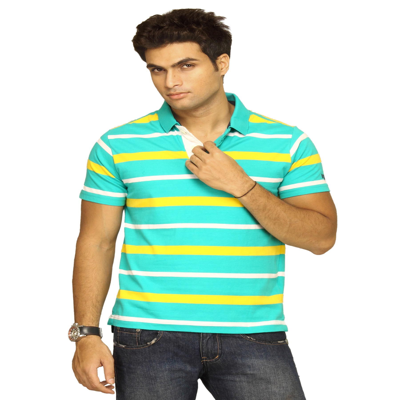

Basics Men Navy Academy Football League Striped Polo T-shirt


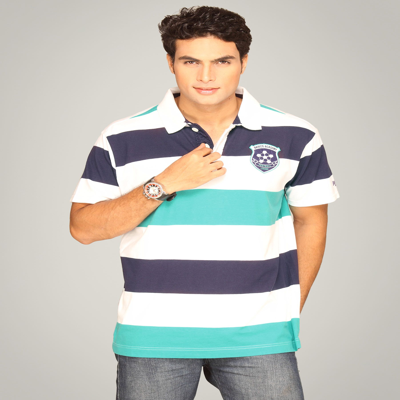

French Connection Women Cream and Navy Blue Striped Top


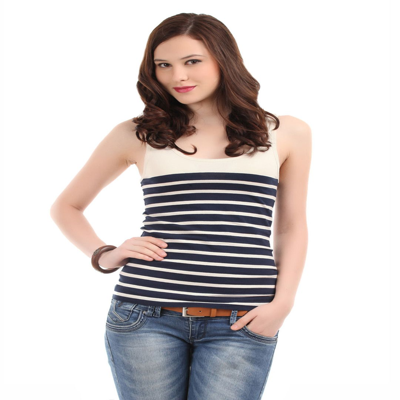

In [28]:
response = fashion_collection.query.near_text(
    query="striped t shirt",  # The model provider integration will automatically vectorize the query
    limit=3
)

for obj in response.objects:
    print(obj.properties["productDisplayName"])
    img = PILImage.open(BytesIO(requests.get((obj.properties['link'])).content))
    img = img.resize((400, 400))
    display(img)

## Hybrid search

**NOTE:** Hybrid search combines the results of a vector search and a keyword (BM25F) search by fusing the two result sets.

**NOTE:** We're using the `rankedFusion` algorithm for fusion, as it provides better results compared to the default `relativeScoreFusion`. You can find more details about the differences between these algorithms in the GitHub repository. Below is a comparison of the outputs from the two fusion algorithms.

In [ ]:
from weaviate.classes.query import HybridFusion

### `rankedFusion`

Fastrack Men Steel Dial Watch


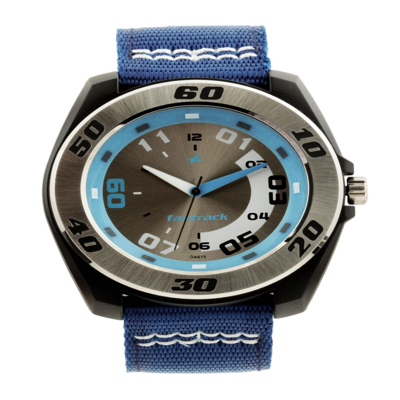

Nike Women Double Team Lite Black Shoes


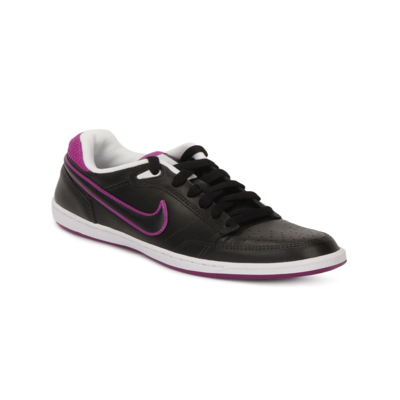

Nike Men Air Max Turbulence White Blue Shoe


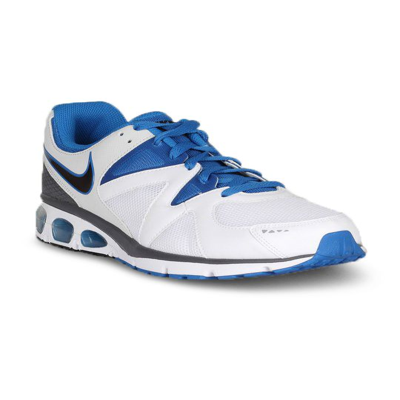

In [86]:
response = fashion_collection.query.hybrid(
    query="watch with backlight",  # The model provider integration will automatically vectorize the query
    fusion_type=HybridFusion.RELATIVE_SCORE,
    limit=3
)

for obj in response.objects:
    print(obj.properties["productDisplayName"])
    img = PILImage.open(BytesIO(requests.get((obj.properties['link'])).content))
    img = img.resize((400, 400))
    display(img)

### `relativeScoreFusion`

Fastrack Men Steel Dial Watch


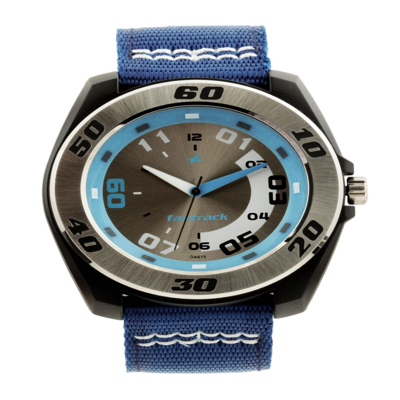

Playboy Women White Dial Watch


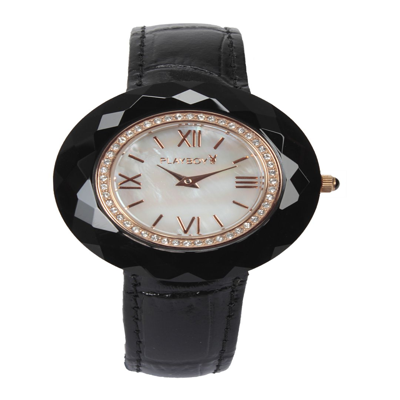

ADIDAS Men Black Dial Watch


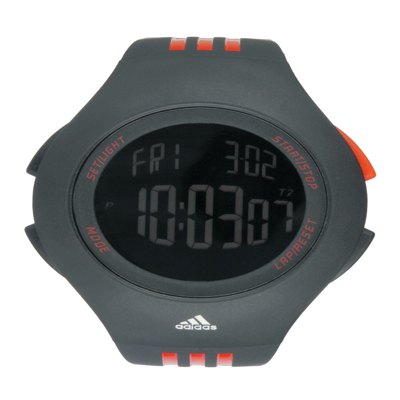

In [87]:
response = fashion_collection.query.hybrid(
    query="watch with backlight",  # The model provider integration will automatically vectorize the query
    fusion_type=HybridFusion.RANKED,
    alpha=0.75, #default value
    limit=3
)

for obj in response.objects:
    print(obj.properties["productDisplayName"])
    img = PILImage.open(BytesIO(requests.get((obj.properties['link'])).content))
    img = img.resize((400, 400))
    display(img)

## Vector (near media) search

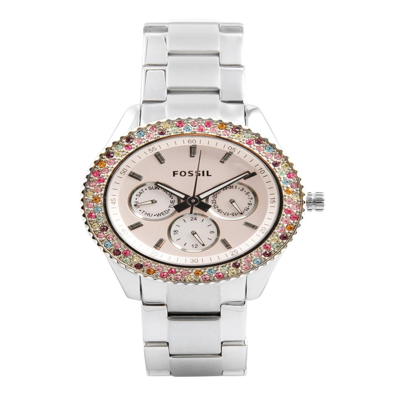

In [41]:
# Run vector search against the below image
src_img_path = 'http://assets.myntassets.com/assets/images/51623/2016/5/20/11463745850786-Fossil-Women-Pink-Dial-Chronograph-Watch-ES3050-9371463745850648-1.jpg'
img = PILImage.open(BytesIO(requests.get(src_img_path).content))
img = img.resize((400, 400))
display(img)

In [42]:
# Function to convert uploaded image to base64 encoded representation
def url_to_base64(url):
    image_response = requests.get(url)
    content = image_response.content
    return base64.b64encode(content).decode("utf-8")

Fossil Women Green Dial Chronograph Watch ES3052


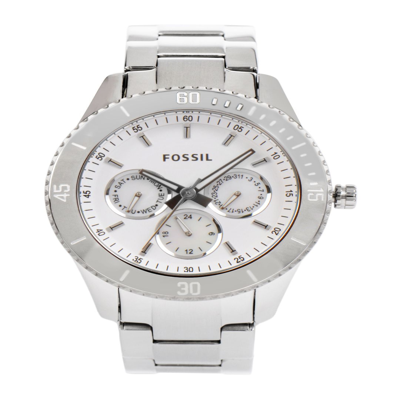

FOSSIL Women White Dial Watch ES3069


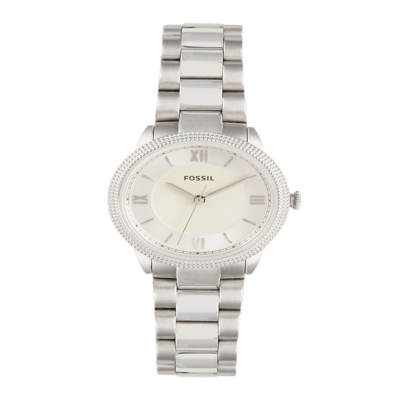

Guess Women Chronograph Silver-Toned Dial Watch W11610L1


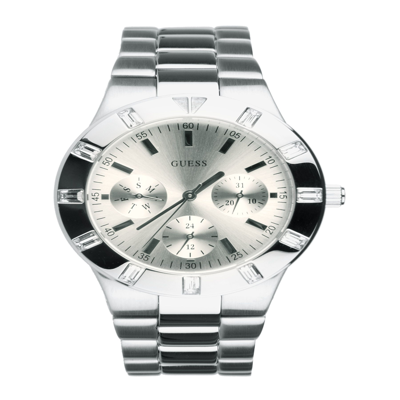

In [44]:
query_b64 = url_to_base64(src_img_path)

response = fashion_collection.query.near_image(
    near_image=query_b64,
    limit=3,
)

for obj in response.objects:
    print(obj.properties["productDisplayName"])
    img = PILImage.open(BytesIO(requests.get((obj.properties['link'])).content))
    img = img.resize((400, 400))
    display(img)

## Search with Filters

In [49]:
from weaviate.classes.query import Filter

Elle Women Off-White & Orange Floral Print Tulip Skirt


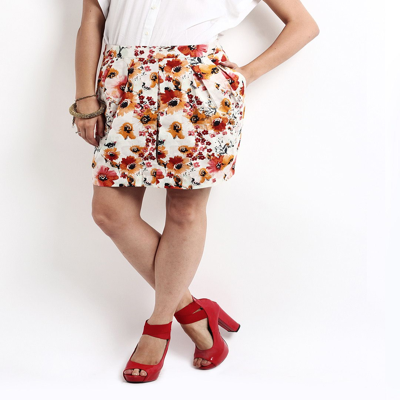

Shree Women Pink Printed Patiala


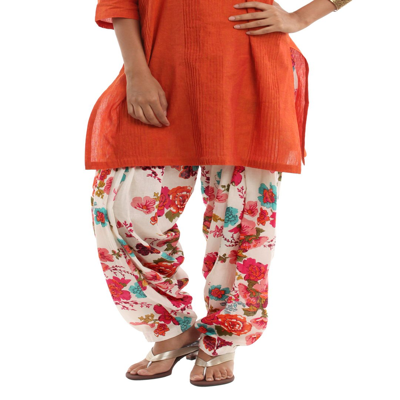

Fabindia Women White Printed Patiala


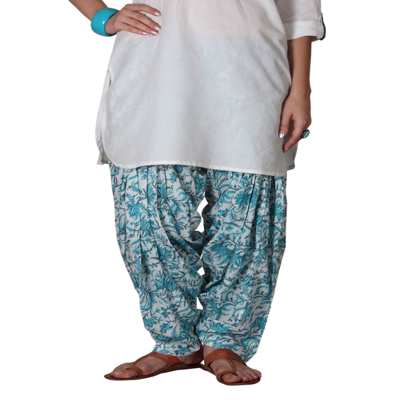

In [51]:
response = fashion_collection.query.hybrid(
    query="floral prints",  # The model provider integration will automatically vectorize the query
    filters=(Filter.by_property("subCategory").equal("Bottomwear")
    ),
    fusion_type=HybridFusion.RANKED,
    alpha=0.75, #default value
    limit=3
)

for obj in response.objects:
    print(obj.properties["productDisplayName"])
    img = PILImage.open(BytesIO(requests.get((obj.properties['link'])).content))
    img = img.resize((400, 400))
    display(img)

# Helper Functions for Streamlit App

**NOTE:** These functions will be used in part 2 of the tutorial.

In [ ]:
# Save the user's uploaded image into the Assests folder
def saveImage(image, file_name):
    img_byte_arr = io.BytesIO()
    image.save(img_byte_arr, format='JPEG')
    img_byte_arr = img_byte_arr.getvalue()

    # Define the directory and file path
    directory = "/content/Assets"
    if not os.path.exists(directory):
        os.makedirs(directory)

    file_path = os.path.join(directory, file_name)

    # Write the uploaded file to the Assets Folder
    with open(file_path, 'wb') as f:
        f.write(img_byte_arr)

    reference_url = os.path.join(directory, file_name)
    return reference_url

In [ ]:
# Function to convert uploaded image to base64 encoded representation
def image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read())
        return encoded_string.decode('utf-8')

In [ ]:
# Function to get recommendations from text query
def get_text_recommendations(query, gender, clothing_types):
    # Create a Filters object
    filters = (
        Filter.by_property("gender").contains_any(gender)
        & Filter.by_property("subCategory").contains_any(clothing_types)
    )

    response = fashion_collection.query.hybrid(
        query=query,
        filters=filters,  # Pass the Filters object
        fusion_type=HybridFusion.RANKED,
        alpha=0.75, #default value
        limit=3
    )

    for obj in response.objects:
        st.write(obj.properties["productDisplayName"])
        # st.write(obj.properties["subCategory"])
        img = PILImage.open(BytesIO(requests.get((obj.properties['link'])).content))
        img = img.resize((500, 500))
        st.image(img)

In [ ]:
# Function to get recommendations from image query
def get_image_recommendations(reference_image_url, gender, clothing_types):
    query_b64 = image_to_base64(reference_image_url)

    # Create a Filters object
    filters = (
        Filter.by_property("gender").contains_any(gender)
        & Filter.by_property("subCategory").contains_any(clothing_types)
    )

    response = fashion_collection.query.near_image(
    near_image=query_b64,
    filters=filters,
    limit=3)

    for obj in response.objects:
        st.write(obj.properties["productDisplayName"])
        img = PILImage.open(BytesIO(requests.get((obj.properties['link'])).content))
        img = img.resize((500, 500))
        st.image(img)

In [ ]:
# Get list of subCategory and ArticleType categories
# Used this to deicide what filters to provide in the app
print(bulk_dataset.subCategory.unique())
print(bulk_dataset.articleType.unique())
# bulk_dataset['subCategory'].value_counts()